In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = 'C:/Users/Shruthi/Documents/HWs/RTML/project/'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "asl_alphabet_train")
print(classes)

image_size = 64*64

['.ipynb_checkpoints', 'asl_alphabet_test', 'asl_alphabet_train', 'Untitled.ipynb']
['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [3]:
transform = tt.Compose(
    [
        tt.Resize(64),
        tt.ToTensor(),
        tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)
dataset = ImageFolder(data_dir+"/asl_alphabet_train", transform)

In [4]:
print(dataset.classes)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [5]:
random_seed = 42
torch.manual_seed(random_seed);
print(len(dataset))

87000


In [6]:
val_size = 7000
test_size = 14000
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

print(len(train_ds), len(val_ds), len(test_ds))

66000 7000 14000


In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
device = get_default_device()
device

device(type='cpu')

In [9]:
batch_size=64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [12]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
                                                       # 3 x 32 x 32
        self.conv1 = conv_block(in_channels, 64)       # 64 x 32 x 32 
        self.conv2 = conv_block(64, 128, pool=True)    # 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) # 128 x 16 x 16
        
        self.conv3 = conv_block(128, 256, pool=True)   # 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True)   # 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 512 x 4 x 4
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), # 512 x 1 x 1
                                        nn.Flatten(),    # 512   
                                        nn.Linear(2048, num_classes)) # 29
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [13]:
model = to_device(ResNet9(3, 29), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
history = [evaluate(model, val_dl)]
history

100%|██████████| 55/55 [02:41<00:00,  2.94s/it]


[{'val_loss': 3.368596076965332, 'val_acc': 0.03534349054098129}]

In [16]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [17]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

100%|██████████| 55/55 [02:13<00:00,  2.43s/it]


Epoch [0], last_lr: 0.00395, train_loss: 0.5363, val_loss: 1.0588, val_acc: 0.8034


100%|██████████| 55/55 [02:03<00:00,  2.25s/it]


Epoch [1], last_lr: 0.00936, train_loss: 0.1959, val_loss: 0.0897, val_acc: 0.9688


100%|██████████| 55/55 [02:05<00:00,  2.27s/it]


Epoch [2], last_lr: 0.00972, train_loss: 0.1072, val_loss: 0.3507, val_acc: 0.8984


100%|██████████| 55/55 [02:02<00:00,  2.24s/it]


Epoch [3], last_lr: 0.00812, train_loss: 0.0673, val_loss: 0.0273, val_acc: 0.9900


100%|██████████| 55/55 [02:01<00:00,  2.20s/it]


Epoch [4], last_lr: 0.00556, train_loss: 0.0432, val_loss: 0.0245, val_acc: 0.9926


100%|██████████| 55/55 [02:08<00:00,  2.34s/it]


Epoch [5], last_lr: 0.00283, train_loss: 0.0167, val_loss: 0.0038, val_acc: 0.9994


100%|██████████| 55/55 [02:27<00:00,  2.68s/it]


Epoch [6], last_lr: 0.00077, train_loss: 0.0022, val_loss: 0.0006, val_acc: 0.9999


100%|██████████| 55/55 [02:20<00:00,  2.55s/it]

Epoch [7], last_lr: 0.00000, train_loss: 0.0003, val_loss: 0.0003, val_acc: 1.0000
Wall time: 8h 35min 5s


In [18]:
torch.save(model.state_dict(), 'resnet9.pth')

In [19]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

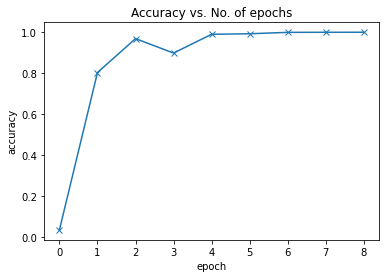

In [20]:
plot_accuracies(history)

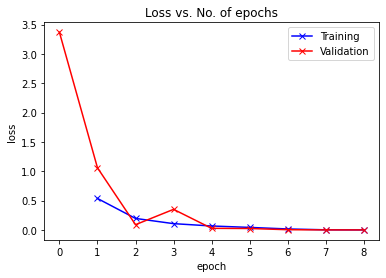

In [21]:
plot_losses(history)

In [27]:
model = to_device(ResNet9(3, 29), device)
model.load_state_dict(torch.load('resnet9.pth'))
model.eval()

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [28]:
evaluate(model, test_dl)

100%|██████████| 110/110 [04:35<00:00,  2.50s/it]


{'val_loss': 0.0002652486728038639, 'val_acc': 1.0}

In [29]:
import torchvision.models as models
from ptflops import get_model_complexity_info

net = model
macs, params = get_model_complexity_info(net, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

ResNet9(
  6.63 M, 100.000% Params, 1.524 GMac, 100.000% MACs, 
  (conv1): Sequential(
    0.002 M, 0.029% Params, 0.008 GMac, 0.533% MACs, 
    (0): Conv2d(0.002 M, 0.027% Params, 0.007 GMac, 0.482% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(0.0 M, 0.002% Params, 0.001 GMac, 0.034% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.017% MACs, inplace=True)
  )
  (conv2): Sequential(
    0.074 M, 1.118% Params, 0.305 GMac, 19.987% MACs, 
    (0): Conv2d(0.074 M, 1.114% Params, 0.303 GMac, 19.849% MACs, 64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(0.0 M, 0.004% Params, 0.001 GMac, 0.069% MACs, 128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0.0 M, 0.000% Params, 0.001 GMac, 0.034% MACs, inplace=True)
    (3): MaxPool2d(0.0 M, 0.000% Params, 0.001 GMac, 0.034% MACs, kernel_size=2, stride=2, padding=0, dilat

In [30]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(6629661,
 [1728,
  64,
  64,
  64,
  73728,
  128,
  128,
  128,
  147456,
  128,
  128,
  128,
  147456,
  128,
  128,
  128,
  294912,
  256,
  256,
  256,
  1179648,
  512,
  512,
  512,
  2359296,
  512,
  512,
  512,
  2359296,
  512,
  512,
  512,
  59392,
  29])